# Extracting lightcurves from Swift UVOT event files


## Introduction

Hello. Today we are going to produce lightcurves from Swift UVOT event files. This will act both as a guide to reproduce the Swift data for GJ 729 that I have placed on the Mega Muscles database, and as a tutorial to extract Swift data from other datasets.

## Preliminaries

Most of the work will be done using HEASOFT. Detailed instructions for extracting lightcurves are given in [Section 2.2 here](https://swift.gsfc.nasa.gov/analysis/UVOT_swguide_v2_2.pdf) Here I will only detial the exact process I used.

The first step is to install the HEASOFT software, following the [instructions here](https://heasarc.gsfc.nasa.gov/lheasoft/install.html). Make sure that ds9 is correctly integrated with HEASOFT-see the related issue [here](https://heasarc.gsfc.nasa.gov/lheasoft/issues.html).

Next, you will need to [install the CALDB database](https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/caldb_intro.html). You can either set up a remote access or make your own local copy. I recommend making a local copy- the disadvantage is that you will have to maintain it yourself, but it makes the lightcurve extraction *much* faster.

## Data
You can get the data from the [Swift archive](https://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/swift.pl). Search for your target, select the dataset(s) you want, then click "Preview and retrieve". This will give you a list of the files associated with that dataset. You need to download the "sat" and "sao" files from the auxiliary data, along with the "uf_evt" file from the UVOT data.

## Lightcurve extraction using HEASOFT
Extracting the lightcurve uses three HEASOFT commands. The first one overwrites the input file, so it's a good idea to make a backup of your .evt file before starting. You should also unzip the event file.

Initialise HEASOFT:
```console
$ heainit
```

Then, run coordinator, filling in the the prompts as so:
```console
$ coordinator
Name of FITS event file to modify[] whatever you called your working .evt file
Name of teldef calibration file or CALDB[]  caldb
Name of FITS attitude file[] path to the "sat" file
R.A. of nominal pointing[] RA of target (degrees)
Declination of nominal pointing[] DEC of target (degrees)
Randomize raw coordinates when rebinning?[] yes
```

HEASOFT will save your choices and display them in the square brackets next time as defaults. Next you need to screen for bad pixels using uvotscreen:
```console
$ uvotscreen
Unfiltered events file[]  whatever you called your working .evt file
Output file name[] whatever you want to call the output .evt file
Orbit and attitude quantities (from prefilter)[] path to the "sao" file
Bad pixel list or NONE indicating not to update QUALITY column[]caldb
Attitude/orbit filtering expression[] SAA == 0
Event table filtering expression[] QUALITY == 0
```

Open the output file in ds9. Your target should be right in the middle of the frame (specifically, the ra and dec positions you gave in coordinator will be in the centre.)
You now need to define two regions using ds9's region tool. "Usource.reg" should be drawn around the target. "Uback.reg" is one or more background regions. I found the resulting extraction to be sensitive to ~0.05 mag by the choice of background region, so I used multiple small regions close to the Usource region. I've included my Usource and Uback regions in this repository, and there are further guidelines about selecting the regions [here](http://www.swift.ac.uk/analysis/uvot/mag.php).

Once you have your regions, you can extract the lightcurve using uvotevtlec. Unlike the previous two commands there are arguments here, the most important being timedel, the cadence in seconds at which you want your lightcurve to be extracted. Here I am extracting at 10s cadence:
```console
$ uvotevtlc timebinalg=u timedel=10
Input event filename [] whatever you called the output name from uvotscreen
Output light curve filename [] name_you_want_for_your_lightcurve.fits
Source region filename [] Usource.reg
Background region filename [] Uback.reg
```

You should now see something like this. Depending on your machine and timestep, it will take a few seconds if you made a local copy of caldb, or tens of minutes if you're accessing caldb remotely
```console
uvotevtlc: running ftmerge
uvotevtlc: running ftsort
uvotevtlc: running ftcopy
uvotevtlc: running ftstat
uvotevtlc: running ftcopy
uvotevtlc: running uvotsource
uvotevtlc: running ftcopy
uvotevtlc: running uvotsource
...
uvotevtlc: running ftcopy
uvotevtlc: running uvotsource
uvotevtlc: running ftappend
```

If you get there without an error message, hooray! You have successfully extracted your lightcurve. Now let's switch to python to look at it.




In [16]:
#import what we're going to need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

For GJ 729, I took the datasets obtianed for Muscles and made 10s cadence lightcurves, saving them in the 10_lightcurves folder. First, let's have a look at them.

In [17]:
path = '10s_lightcurves'
lcs = glob.glob(path+'/*.fits')

In [18]:
lcs

['10s_lightcurves/sw00031677006uuuw1po_lc10.fits',
 '10s_lightcurves/sw00031677004uuuw1po_lc10.fits',
 '10s_lightcurves/sw00031677008uuuw1po_lc10.fits',
 '10s_lightcurves/sw00031677005uuuw1po_lc10.fits',
 '10s_lightcurves/sw00031677007uuuw1po_lc10.fits',
 '10s_lightcurves/sw00031677003uuuw1po_lc10.fits']

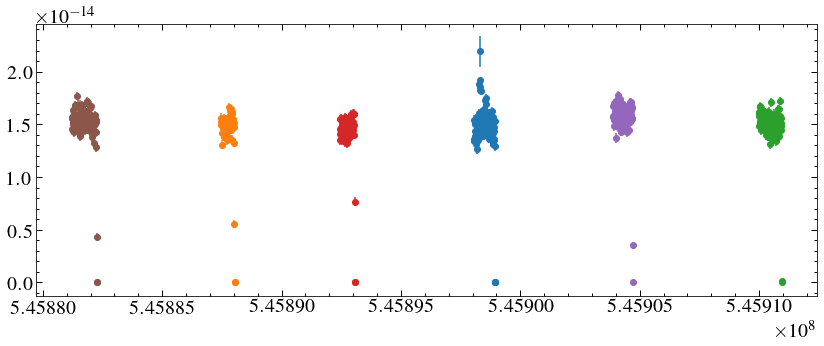

In [19]:
for lc in lcs:
         data = fits.getdata(lc, 1)
         plt.errorbar(data['TIME'], data['AB_FLUX_AA'], yerr = data['AB_FLUX_AA_ERR'], marker='o', ls='none')


Look at the lovely flare! Ok, what do we want to do with this?
* Convert the time into absolute time.
* Remove the dodgy final points.
* Save to a .dat file with time, flux, error
The last one is for convenience, as it is easier to work with than the busy fits file. The low final points are due to UVOTEVTLC not handling fractional timesteps well. 

For the time, we need to convert into seconds since mjd = 0. The reference day is stored in the header, but for ease of reference it is 2001 January 1st 00:00:00, or: 

In [20]:
ref_mjd = 51910
ref_sec = ref_mjd * 86400

If that has worked, it should line up with the flare we observed with HST. Let's grab the HST lightcurve, which I've put into this directory.

<ErrorbarContainer object of 3 artists>

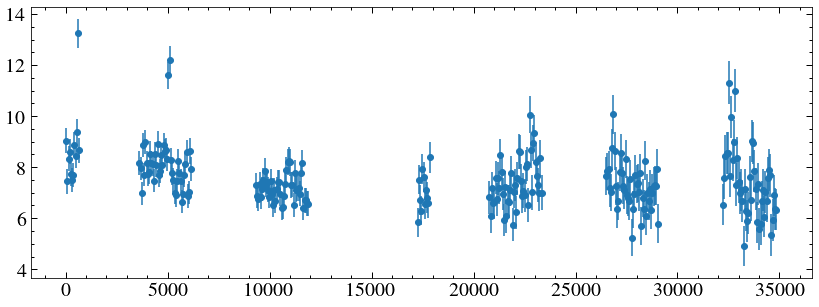

In [21]:
lc = Table.read('gj729_60s_lightcurve_counts.ecsv')
plt.errorbar(lc['t'], lc['f'], yerr=lc['e'], marker = 'o', ls='none')

We also need to convert the HST data into absolute time. We need to know the starting exposure. The lightcurve is made of multiple exposures, so I went and found the first exposure to get t==0. The first spectrum is ODLM38030, and the x1d file records that the exposure started at:

In [22]:
hst_mjd= 5.822800374121E+04
hst_sec = hst_mjd*86400

So with these conversions, the two lightcurves (normalised) should line up! First though we need to clear out the nans, then we can plot both lightcurves together.

In [23]:
mask = np.isnan(lc['f'])==False
lc_m = lc[mask]

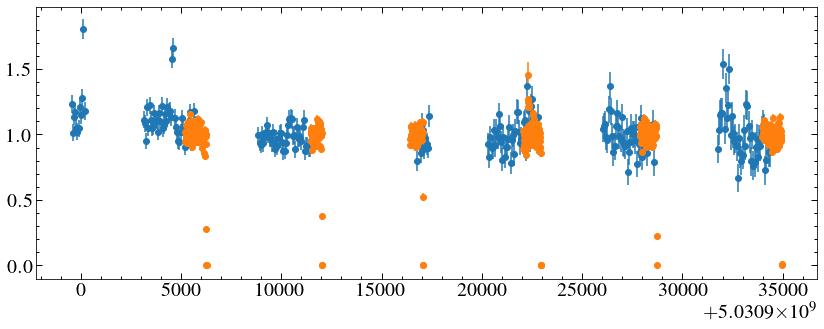

In [24]:

plt.errorbar(lc_m['t']+hst_sec ,lc_m['f']/np.median(lc_m['f']) , yerr=lc_m['e']/np.median(lc_m['f']), marker = 'o', ls='none')
for uvot_lc in lcs:
         data = fits.getdata(uvot_lc, 1)
         plt.errorbar(data['TIME']+ref_sec, data['AB_FLUX_AA']/np.median(data['AB_FLUX_AA']), yerr = data['AB_FLUX_AA_ERR']/np.median(data['AB_FLUX_AA']), marker='o', ls='none', c='C1')

Perfect! And look how well that flare aligns. Let's zoom in and bask in our glorious observation.

Text(0, 0.5, 'Normalised Flux')

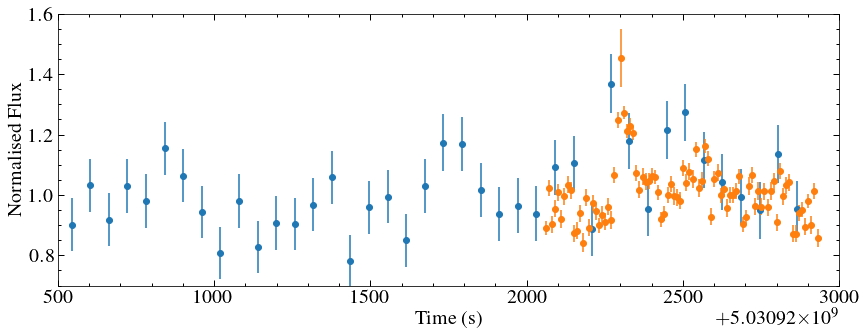

In [25]:
plt.errorbar(lc_m['t']+hst_sec ,lc_m['f']/np.median(lc_m['f']) , yerr=lc_m['e']/np.median(lc_m['f']), marker = 'o', ls='none')

#plt.errorbar(t_abs, f_n, yerr=e_n, marker = 'o', ls='none')
for uvot_lc in lcs:
         data = fits.getdata(uvot_lc, 1)
         plt.errorbar(data['TIME']+ref_sec, data['AB_FLUX_AA']/np.median(data['AB_FLUX_AA']), yerr = data['AB_FLUX_AA_ERR']/np.median(data['AB_FLUX_AA']), marker='o', ls='none', c='C1')
plt.xlim(20500+5.0309e9, 23000+5.0309E9)
plt.ylim(0.7, 1.6) 
plt.xlabel('Time (s)')
plt.ylabel('Normalised Flux')

For ease of work, we'll put the Swift data into one file. As I have plenty of points here I don't care about losing the incorrectly extracted data points, so I'll just remove them. For longer cadence lightcurves you may want to do better. I'll try looking into this again at some point. 

In [26]:
t = np.array([], dtype=float)
f = np.array([], dtype=float)
e = np.array([], dtype=float)

for uvot_lc in lcs:
    data = fits.getdata(uvot_lc, 1)#
    t = np.concatenate((t, data['TIME'][:-3]+ref_sec))
    f = np.concatenate((f, data['AB_FLUX_AA'][:-3]))
    e = np.concatenate((e, data['AB_FLUX_AA_ERR'][:-3]))

<ErrorbarContainer object of 3 artists>

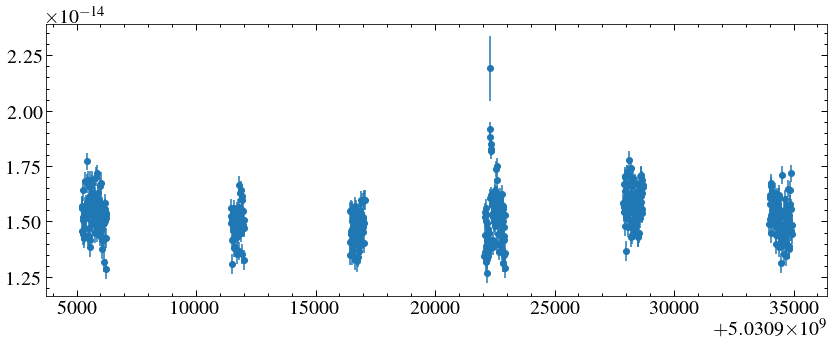

In [27]:
plt.errorbar(t, f, yerr=e, marker='o', ls='none')

Finally, we'll save the combined lightcurve to a csv file.

In [28]:
fl = open('GJ_729_UVOT_U_10slc.csv', 'w')
fl.write('t,f,e\n')
for a, b, c in zip(t, f,e):
    fl.write('%f,%g,%g\n'%(a, b, c))

And just to check that that worked...

In [29]:
lc_new = Table.read('GJ_729_UVOT_U_10slc.csv')
lc_new

t,f,e
float64,float64,float64
5030922060.97734,1.34434e-14,3.52406e-16
5030922070.97734,1.54435e-14,3.9931e-16
5030922080.97734,1.36068e-14,4.10862e-16
5030922090.97734,1.43959e-14,4.05423e-16
5030922100.97734,1.5197e-14,4.31399e-16
5030922110.97734,1.3885e-14,4.54292e-16
5030922120.97734,1.49983e-14,4.25496e-16
5030922130.97734,1.55907e-14,4.09002e-16
5030922140.97734,1.5296e-14,4.24497e-16


Excellent. Well done everyone, time for tea.

20180917 -making a nicer plot of the simultaneous flare

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


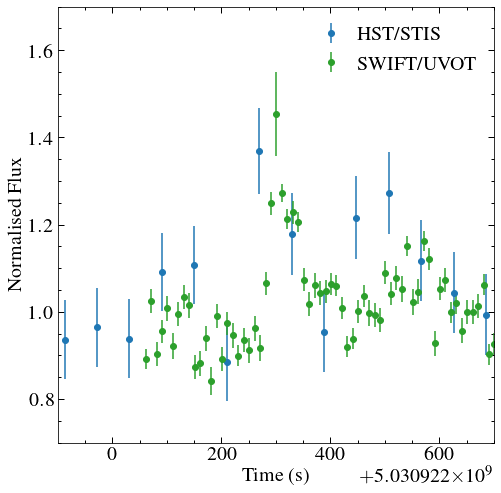

In [30]:
plt.figure(figsize=(7,7))
plt.subplots_adjust(top=0.99, right=0.99)
plt.errorbar(lc_m['t']+hst_sec ,lc_m['f']/np.median(lc_m['f']) , yerr=lc_m['e']/np.median(lc_m['f']), marker = 'o', ls='none', label ='HST/STIS')

#plt.errorbar(t_abs, f_n, yerr=e_n, marker = 'o', ls='none')
for uvot_lc in lcs:
         data = fits.getdata(uvot_lc, 1)
         plt.errorbar(data['TIME']+ref_sec, data['AB_FLUX_AA']/np.median(data['AB_FLUX_AA']), yerr = data['AB_FLUX_AA_ERR']/np.median(data['AB_FLUX_AA']), marker='o', ls='none', c='C2')
plt.errorbar(1,1,yerr=1,label='SWIFT/UVOT', color='C2', marker='o', ls='none')
plt.xlim(21900+5.0309e9, 22700+5.0309E9)
plt.ylim(0.7, 1.7) 
plt.xlabel('Time (s)')
plt.ylabel('Normalised Flux')
plt.legend()
#plt.savefig('gj729_hst_v_swift_zoom.pdf', dpi=150)

20210916 Need a u-band flux

1.529230894365945e-14 2.160386205122546e-17
1.5238676427176175e-14 8.87808924300595e-16


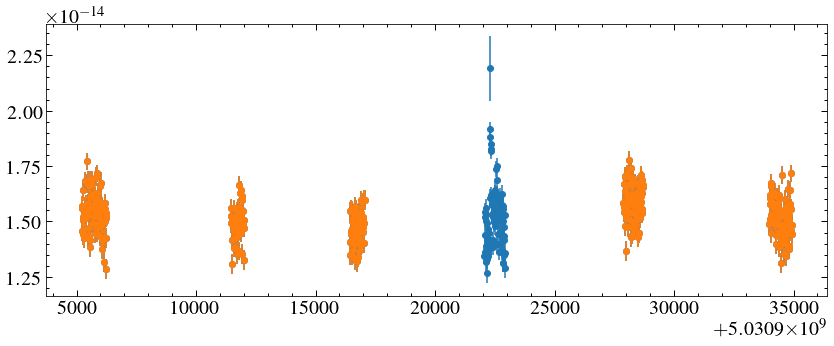

In [42]:

plt.errorbar(t, f, yerr=e, marker='o', ls='none')
mask = (t < 5.030922e9) | (t >  5.030923e9) #mask out flare
plt.errorbar(t[mask], f[mask], yerr=e[mask], marker='o', ls='none')

swift_flux = np.average(f[mask], weights = 1/(e[mask]**2))
swift_error =  (1 / np.sum(1/(e[mask]**2)))**0.5
print(swift_flux, swift_error)

print(np.mean(f[mask]), np.std(f[mask]))